In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim
#from torch.distributions import Gamma
#torch.manual_seed(1)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import MultipleLocator # for minor ticks
from matplotlib import gridspec
from matplotlib import patches

import numpy as np

import scipy.stats as scstats
import scipy.special as sps

import pickle 

import sys
sys.path.append("../..")

from neuroprob.utils import stats, tools, neural_utils
import neuroprob.models as mdl

from tqdm.autonotebook import tqdm

dev = tools.PyTorch()
#dev = torch.device("cuda:{}".format(0))

plt.style.use(['paper.mplstyle'])

PyTorch version: 1.6.0+cu101
Using device: cuda:0


### GP lengthscale versus kernel lengthscale versus histogram binning

In [2]:
# Synthetic data
sample_bin, track_samples, x_t, y_t, s_t, hd_t, theta_t, dir_t, \
    syn_t_spike, spike_samples, units, \
    left_x, right_x, bottom_y, top_y = pickle.load(open('../data/synthetic/gauss_spat_IPP.p', 'rb'))

fac = 1000.

max_speed = s_t.max()/fac
wrap_theta_t = tools.WrapPi(theta_t, True)

right_x = right_x/fac
left_x = left_x/fac
top_y = top_y/fac
bottom_y = bottom_y/fac

arena_width = right_x - left_x
arena_height = top_y - bottom_y
behav_data = [x_t/fac, y_t/fac]


bin_size = 1
tbin, resamples, rc_t, _ = neural_utils.BinTrain(bin_size, sample_bin, syn_t_spike, 
                                                 track_samples, binned=False)


In [3]:
def generate_hist_model(bins_x):
    bins_y = int(arena_height/arena_width*bins_x)
    bin_x = np.linspace(left_x, right_x+1e-3, bins_x+1)
    bin_y = np.linspace(bottom_y, top_y+1e-3, bins_y+1)
    bins_tuple = (bin_x, bin_y)
    
    model = mdl.nonparametrics.histogram(bins_tuple, neurons=1)
    return model


def bin_to_l(bins_x): # lengthscales
    l_x = arena_width / bins_x
    return l_x


def histogram_select(binning, folds): # binnings
    binnings = len(binning)
    
    AIC = np.empty((units, binnings))
    BIC = np.empty((units, binnings))
    nll = np.empty((units, binnings))
    CVs = np.empty((units, binnings, folds))

    for u in range(units):
        print(u)
        cv_set = neural_utils.SpikeTrainCV(folds, rc_t[u:u+1], track_samples, behav_data)
    
        for k in range(binnings):
            print(k, end=' ')
            def rate_func(behav_list, spiketrain):
                bins_x = binning[k]
                model = generate_hist_model(bins_x)
                
                spiketimes = neural_utils.BinToTrain(spiketrain[0])
                rate, prob = neural_utils.IPP_model(tbin, behav_list, model.bins_cov, [spiketimes], bin_thres=0.125)
                model.set_params(tbin, w=rate)

                likelihood = mdl.likelihoods.Poisson(1, 'identity')
                likelihood.set_params(tbin)
                
                glm = mdl.inference.nll_optimized([model], likelihood)
                params = (prob > 0).sum() # visited bins
                return glm, params

            AIC[u, k], BIC[u, k], nll[u, k] = neural_utils.model_selection(rate_func, behav_data, rc_t[u:u+1])#, dev=dev)
            CVs[u, k] = neural_utils.model_cv(rate_func, cv_set)#, dev=dev)
            
    return AIC, BIC, nll, CVs


def fit_kernel_model(L, model, behav_list, spiketimes):
    r"""
    The kernel method is approximated by a fine histogram model to speed up computation 
    with high number of spikes. The raw histogram is smoothed with a kernel.
    """
    bin_x, bin_y = model.bins_cov
    sp_act, sp_time = neural_utils.IPP_model(tbin, behav_list, model.bins_cov, spiketimes, divide=False)
    
    delta_bin_x = bin_x[1] - bin_x[0]
    delta_bin_y = bin_y[1] - bin_y[0]

    sm_size_x = 31
    centre_x = sm_size_x // 2
    sm_size_y = 31
    centre_y = sm_size_y // 2

    sm_filter = np.empty((sm_size_x, sm_size_y))
    for k in range(sm_size_x):
        for l in range(sm_size_y):
            sm_filter[k, l] = np.exp( -0.5*(((k-centre_x)*delta_bin_x/L[0])**2 + ((l-centre_y)*delta_bin_y/L[1])**2) )

    sm_filter = sm_filter / sm_filter.sum()

    smth_act = neural_utils.smooth_hist(sp_act, sm_filter, ['repeat', 'repeat'], dev=dev)
    smth_time = neural_utils.smooth_hist(sp_time[None, ...], sm_filter, ['repeat', 'repeat'], dev=dev)
    smth_rate = smth_act/smth_time
    
    model.set_params(tbin, w=smth_rate)
    return model



def kernel_select(Lscales, folds): # fields
    bins_x = 100
    CVs = np.empty((units, lscales, folds))
    
    hist_model = generate_hist_model(bins_x)
    likelihood = mdl.likelihoods.Poisson(1, 'identity')
    likelihood.set_params(tbin)
    
    for u in range(units):
        print(u)
        cv_set = neural_utils.SpikeTrainCV(folds, rc_t[u:u+1], track_samples, behav_data)
        
        for k, l_ in enumerate(Lscales):
            print(k, end=' ')
            L = [l_, l_]

            def rate_func(behav_list, spiketrain):
                spiketimes = neural_utils.BinToTrain(spiketrain[0])
                model = fit_kernel_model(L, hist_model, behav_list, [spiketimes])
                
                glm = mdl.inference.nll_optimized([model], likelihood)
                return glm, len(L)

            CVs[u, k] = neural_utils.model_cv(rate_func, cv_set)#, dev=dev)
            
    return CVs

In [4]:
def get_field(glm_rate, grid_size, grid_shape, neuron):

    def func(pos):
        prevshape = pos.shape[1:]
        x = pos[0].flatten()
        y = pos[1].flatten()
        covariates = [x, y]
        return glm_rate.eval_rate(covariates, neuron).reshape(-1, *prevshape)

    _, field = tools.compute_mesh(grid_size, grid_shape, func)
    return field


def compute_rate(glm_rate, neuron):
    grid_size = (30, 24)
    dx = arena_width/grid_size[0]
    dy = arena_height/grid_size[1]
    grid_shape = [[left_x+dx/2., right_x-dx/2.], [bottom_y+dy/2., top_y-dy/2.]]
    field = get_field(glm_rate, grid_size, grid_shape, neuron)
    return field


def compute_RMS(true_w, model_w): # rate error, with shape (neuron,)
    return np.sqrt(((model_w-true_w)**2).mean(axis=(1, 2)))
    
    
def compute_stats(glm_rate, behav_data, t_spike): # statistics
    bs = 5000
    T = behav_data[0].shape[0]
    N = int(np.ceil(T/bs))
    rate_model= []

    for n in range(N):
        covariates_ = [b[n*bs:(n+1)*bs] for b in behav_data]
        rate_model += [glm_rate.eval_rate(covariates_, [0])[0]]

    rate_model = np.concatenate(rate_model)

    # Overdispersion count method
    #traj_len = 1000
    #q_cdf_, q_order_, py, T_DS, T_KS, s_DS, s_KS_, p_DS_, p_KS_, traj_lens = \
    #    stats.count_KS_method(sample_bin, t_spike, rate_model, traj_len, min_spikes=10, repeat=1)

    # ISI KS-method
    dist_isi = mdl.point_process.ISI_gamma(np.array([1.0]))
    q_cdf, Z_DS, T_KS, s_DS, s_KS, p_DS, p_KS = \
        stats.ISI_KS_method(dist_isi, sample_bin, t_spike, rate_model)

    return q_cdf, Z_DS, T_KS, s_KS

In [46]:
def GT_model():
    tmu = np.array([[250., 250.], [100., 100.], [400., 300.], [50., 350.], [360., 70.]])/fac
    tprec = np.array([[0.0001, 0.0001, 0.00005], [0.0002, 0.0002, 0.0], [0.0001, 0.0002, 0.00005], 
                     [0.0001, 0.0002, 0.0], [0.00015, 0.00015, 0.0]])*fac**2
    trate_0 = np.array([8.0, 20.0, 10.0, 17.0, 12.0]) # Hz
    tt_p = np.array([[0.0, 0.0], [1.0, 0.2], [0.5, 0.0], [0.7, 1.0], [0.1, 0.0]]) # beta, phi_0 for theta modulation

    glm_rate = mdl.parametrics.Gauss_GLM(units, 'exp')
    w = mdl.parametrics.gaussian_to_w(tmu, tprec, trate_0, tt_p)[:, :6]
    glm_rate.set_params(sample_bin, w)
    return glm_rate
        

def fit_and_return_model(model_type, behav_list, spiketrain, optimal_l): # single neuron fits
    if model_type == 'gaussian': # Gaussian fit
        ll_samples = 1
        
        # single neuron initialization
        spiketimes = neural_utils.BinToTrain(spiketrain[0])
        x_s, y_s = neural_utils.CovariatesAtSpikes([spiketimes], tuple(behav_list))
        imu = np.empty((1, 2))
        iprec = np.empty((1, 3))
        irate_0 = 10.*np.ones((1)) # Hz
        it_p = np.zeros((1, 2)) # beta, phi_0 for theta modulation

        imu[0, 0] = x_s[0].mean()
        imu[0, 1] = y_s[0].mean()
        iprec[0, 0] = 1/x_s[0].var()
        iprec[0, 1] = 1/y_s[0].var()

        glm_rate = mdl.parametrics.Gauss_GLM(1, 'exp')
        glm_rate.set_params(sample_bin, mdl.parametrics.gaussian_to_w(imu, iprec, irate_0, it_p)[:, :6])
        
    elif model_type == 'histogram': # histogram fit
        bins_x = optimal_l
        glm_rate = generate_hist_model(bins_x)

        spiketimes = neural_utils.BinToTrain(spiketrain[0])
        rate, prob = neural_utils.IPP_model(tbin, behav_list, glm_rate.bins_cov, [spiketimes], bin_thres=0.125)
        glm_rate.set_params(tbin, w=rate)
        glm_rate.to(dev)
        return glm_rate
        
    elif model_type == 'kernel': # kernel method rate
        bins_x = 100
        hist_model = generate_hist_model(bins_x)

        L = [optimal_l, optimal_l]
        spiketimes = neural_utils.BinToTrain(spiketrain[0])
        glm_rate = fit_kernel_model(L, hist_model, behav_list, [spiketimes])
        glm_rate.to(dev)
        return glm_rate
        
    elif model_type == 'GP': # Gaussian process
        ll_samples = 10
        num_induc = 30
        ind_list = [np.linspace(left_x, right_x, num_induc), \
                    bottom_y + arena_height*np.random.rand(num_induc)]

        l = 30.*np.ones(1)/fac
        v = np.ones(1)
        kt = [('RBF', 'euclid', np.array([l, l]), v)] # shared lengthscales x and y
        
        inducing_points = np.array([left_x + arena_width*np.random.rand(num_induc), \
                                    bottom_y + arena_height*np.random.rand(num_induc)]).T

        inducing_points = np.array(ind_list).T[None, ...].repeat(1, axis=0)
        glm_rate = mdl.nonparametrics.Gaussian_process(1, inducing_points, kt,
                                                    ([None],)*2, ([None],)*2, 
                                                    inv_link='exp', shared_kernel_params=True,
                                                    full_cov_fit=False, 
                                                    mean_ini=np.zeros((1, 1, 1)))
        glm_rate.set_params(jitter=1e-5)
    
    glm_rate.set_params(tbin)
    likelihood = mdl.likelihoods.Poisson(1, 'exp')
    likelihood.set_params(tbin)
        
    glm = mdl.inference.nll_optimized([glm_rate], likelihood)
    glm.preprocess(behav_list, spiketrain.shape[1], spiketrain, batch_size=100000)
    glm.to(dev)

    # fit
    sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
    opt_tuple = (optim.Adam, 100, sch)
    opt_lr_dict = {'default': 5*1e-3}
    glm.set_optimizers(opt_tuple, opt_lr_dict)

    annealing = lambda x: 1.0#min(1.0, 0.01*x)
    losses = glm.fit(3000, margin=1e1, premature=100, anneal_func=annealing, ll_samples=ll_samples)

    # training
    plt.figure()
    plt.plot(losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()
    
    return glm_rate

In [41]:
show_field = []
binning = [3, 4, 5, 6, 8, 10, 12, 15, 20, 30, 40]
folds = 5

lscales = len(binning)
Lscales = [bin_to_l(g) for g in binning]#np.linspace(0.005, .1, lscales)

AIC, BIC, nll, CVs = histogram_select(binning, folds)
CVs_kernel = kernel_select(Lscales, folds)
CV = CVs.mean(-1)
CV_kernel = CVs_kernel.mean(-1)

optimal_bin = np.empty((units))
optimal_length = np.empty((units))
for u in range(units):
    optimal_bin[u] = binning[np.argmin(CV[u])]
    optimal_length[u] = Lscales[np.argmin(CV_kernel[u])]
    
hist_lengthscales = bin_to_l(optimal_bin)
    
# compute show models
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
u_show = 0
u = u_show

glm_rate = fit_and_return_model('histogram', behav_data, rc_t[u:u+1], 20)
grid_size = [len(glm_rate.bins_cov[0])-1, len(glm_rate.bins_cov[1])-1]
show_field.append(get_field(glm_rate, grid_size, grid_shape, [0])[0])

glm_rate = fit_and_return_model('histogram', behav_data, rc_t[u:u+1], 6)
grid_size = [len(glm_rate.bins_cov[0])-1, len(glm_rate.bins_cov[1])-1]
show_field.append(get_field(glm_rate, grid_size, grid_shape, [0])[0])

glm_rate = fit_and_return_model('kernel', behav_data, rc_t[u:u+1], .01)
grid_size = [50, 40]
show_field.append(get_field(glm_rate, grid_size, grid_shape, [0])[0])

glm_rate = fit_and_return_model('kernel', behav_data, rc_t[u:u+1], .09)
grid_size = [50, 40]
show_field.append(get_field(glm_rate, grid_size, grid_shape, [0])[0])

0
0 1 2 3 4 5 6 7 8 9 10 1
0 1 2 3 4 5 6 7 8 9 10 2
0 1 2 3 4 5 6 7 8 9 10 3
0 1 2 3 4 5 6 7 8 9 10 4
0 1 2 3 4 5 6 7 8 9 10 0
0 1 2 3 4 5 6 7 8 9 10 1
0 1 2 3 4 5 6 7 8 9 10 2
0 1 2 3 4 5 6 7 8 9 10 3
0 1 2 3 4 5 6 7 8 9 10 4
0 1 2 3 4 5 6 7 8 9 10 


Stopped at epoch 235.


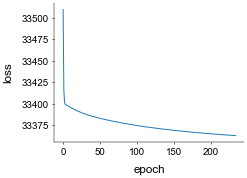


Stopped at epoch 229.


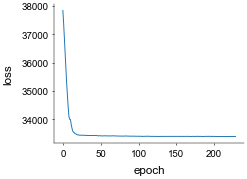


Stopped at epoch 278.


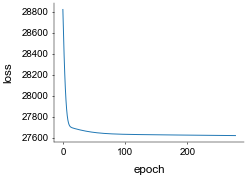


Stopped at epoch 303.


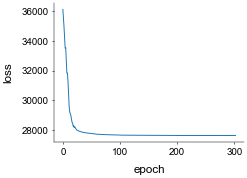


Stopped at epoch 244.


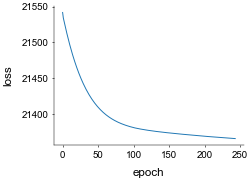


Stopped at epoch 305.


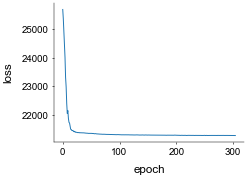


Stopped at epoch 698.


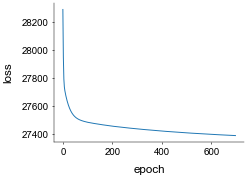


Stopped at epoch 300.


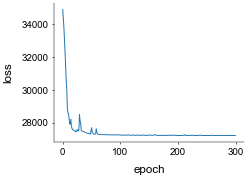


Stopped at epoch 183.


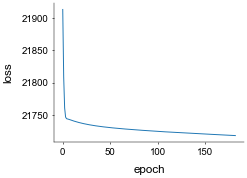


Stopped at epoch 315.


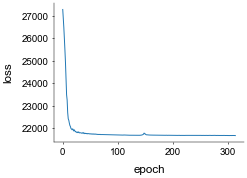

In [64]:
# computation
gt_rate = GT_model()
model_types = ['gaussian', 'histogram', 'kernel', 'GP']
train_size = 2500000
field_tuples = []

RMS_ = []
stats_ = []
lengthscale = []


grid_size = [50, 40]
grid_shape = [[left_x, right_x], [bottom_y, top_y]]
true_field = get_field(gt_rate, grid_size, grid_shape, np.arange(units))


for u in range(units):
    t_rate = compute_rate(gt_rate, neuron=[u])
    
    RMS = []
    stats_list = []
    
    
    for model_type in model_types:
        if model_type == 'histogram':
            opt_l = int(optimal_bin[u])
        elif model_type == 'kernel':
            opt_l = optimal_length[u]
        else:
            opt_l = None
        glm_rate = fit_and_return_model(model_type, [b[:train_size] for b in behav_data], 
                                        rc_t[u:u+1, :train_size], opt_l)
        
        m_rate = compute_rate(glm_rate, [0])[0]
        RMS.append(compute_RMS(t_rate, m_rate))
        # evaluate predictive T scores
        stats_list.append(compute_stats(glm_rate, [b[train_size:] for b in behav_data], 
                                        syn_t_spike[u][syn_t_spike[u] > train_size]-train_size))
        
        if model_type == 'GP':
            lengthscale.append(glm_rate.kernel.lengthscale.data.cpu().numpy())
            
        grid_shape = [[left_x, right_x], [bottom_y, top_y]]
        if model_type == 'histogram':
            grid_size = [len(glm_rate.bins_cov[0])-1, len(glm_rate.bins_cov[1])-1]
        else:
            grid_size = [50, 40]
            
        if u == 0:
            field_tuples.append(get_field(glm_rate, grid_size, grid_shape, [0])[0])

    RMS_.append(RMS)
    stats_.append(stats_list)

lengthscale = np.array(lengthscale)
RMS_ = np.array(RMS_)

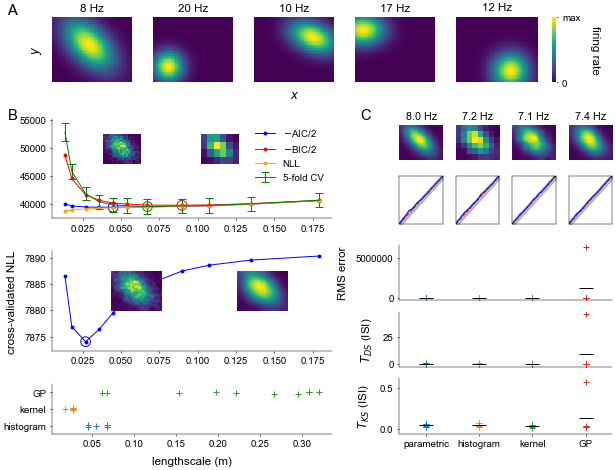

In [62]:
fig = plt.figure(figsize=(8,6))
fig.text(-0.08, 1.0, 'A', transform=fig.transFigure, size=15)
fig.text(-0.08, 0.75, 'B', transform=fig.transFigure, size=15)
fig.text(0.55, 0.75, 'C', transform=fig.transFigure, size=15)



### show true fields ###
grid_shape = [[left_x, right_x], [bottom_y, top_y]]


widths = [1, 1, 1, 1, 1, 0.25]
heights = [1]
nrows = 1
ncols = 6
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                         height_ratios=heights, wspace=0.25, left=0.0, right=0.9, bottom=0.83, top=1.0)


for u in range(units):
    ax = fig.add_subplot(spec[0, u])
    
    if u == 4:
        cbar= True
        ticktitle='firing rate'
        cax = fig.add_subplot(spec[0, 5])
    else:
        cbar = False
        ticktitle=''
        cax = None
        
    ax.set_title('{:.0f} Hz'.format(true_field[u].max()), fontsize=12)
    _, ax = tools.visualize_field(true_field[u], grid_shape, ticktitle=ticktitle, figax=(fig, ax), 
                                  ticks=[0, true_field[u].max()], ticklabels=['0', 'max'], cbar=cbar, 
                                  cax=cax)
    if u == 0:
        ax.set_ylabel(r'$y$')
    if u == 2:
        ax.set_xlabel(r'$x$')

    #tools.decorate_ax(ax, ylabel=ylabel, xlim=[left_x, right_x], ylim=[bottom_y, top_y])



### show model selection ###
widths = [1]
heights = [2, 2, 1]
nrows = 3
ncols = 1
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths, hspace=0.4, 
                        height_ratios=heights, left=0., right=.5, bottom=0.0, top=.75)


# histogram
binnings = len(binning)
b = []
for bb in binning:
    b.append(bin_to_l(bb))
b = np.array(b)

CV_mean = CVs.mean(-1)
CV_std = CVs.std(-1)

ax = fig.add_subplot(spec[0, 0])
ax.plot(b, AIC[u_show]/2., label='$-$AIC/2', marker='o', color='blue')
ax.plot(b, BIC[u_show]/2., label='$-$BIC/2', marker='o', color='red')
ax.plot(b, nll[u_show], label='NLL', marker='o', color='orange')
ax.errorbar(b, folds*CV_mean[u_show], yerr=CV_std[u_show], capsize=4, 
            label='{}-fold CV'.format(folds), color='green')

ax.scatter(b[np.argmin(AIC[u_show])], np.min(AIC[u_show]/2.), marker='o', 
           facecolor='None', edgecolors='blue', s=100)
ax.scatter(b[np.argmin(BIC[u_show])], np.min(BIC[u_show]/2.), marker='o', 
           facecolor='None', edgecolors='red', s=100)
#ax.scatter(b[np.argmin(nll[u_show])], np.min(nll[u_show]), marker='o', 
#           facecolor='None', edgecolors='tab:orange', s=100)
ax.scatter(b[np.argmin(CV_mean[u_show])], np.min(folds*CV_mean[u_show]), marker='o', 
           facecolor='None', edgecolors='green', s=100)
ax.legend()


axes = ax.inset_axes([0.05, 0.55, 0.4, 0.3])
tools.visualize_field(show_field[0], grid_shape, cbar=False, figax=(fig, axes))
axes = ax.inset_axes([0.4, 0.55, 0.4, 0.3])
tools.visualize_field(show_field[1], grid_shape, cbar=False, figax=(fig, axes))

# kernel
ax = fig.add_subplot(spec[1, 0])

CV = CVs_kernel.mean(-1)
ax.plot(Lscales, CV[u_show], marker='o', color='blue')
ax.scatter(Lscales[np.argmin(CV[u_show])], np.min(CV[u_show]), marker='o', facecolor='None', 
           edgecolors='blue', s=100)

ax.set_ylabel('cross-validated NLL')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4, 4))

axes = ax.inset_axes([0.05, 0.4, 0.5, 0.4])
tools.visualize_field(show_field[2], grid_shape, cbar=False, figax=(fig, axes))
axes.set_alpha(0.5)
axes = ax.inset_axes([0.5, 0.4, 0.5, 0.4])
tools.visualize_field(show_field[3], grid_shape, cbar=False, figax=(fig, axes))
axes.set_alpha(0.5)

# lengthscale comparison
ax = fig.add_subplot(spec[2, 0])
ax.scatter(hist_lengthscales, np.ones_like(hist_lengthscales)+(np.random.rand(*hist_lengthscales.shape)-0.5)*0.2, 
           marker='+', s=40)
ax.scatter(optimal_length, np.ones_like(optimal_length)*2+(np.random.rand(*optimal_length.shape)-0.5)*0.2, 
           marker='+', s=40)
gp_l = np.array(lengthscale).flatten()
ax.scatter(gp_l, np.ones_like(gp_l)*3+(np.random.rand(*gp_l.shape)-0.5)*0.2, marker='+', s=40)
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['histogram', 'kernel', 'GP'])
ax.set_xlabel('lengthscale (m)')
ax.set_ylim(0.5, 3.5)


### show goodness of fits
widths = [1, 1, 1, 1]
heights = [1, 1]
nrows = 2
ncols = 4
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                        height_ratios=heights, wspace=.3, left=0.62, right=1., bottom=0.5, top=.75)

# plots
for u in range(len(model_types)):
    ax = fig.add_subplot(spec[0, u])
    ax.set_title('{:.1f} Hz'.format(field_tuples[u].max()), fontsize=11)
    _, ax = tools.visualize_field(field_tuples[u], grid_shape, ticktitle=ticktitle, figax=(fig, ax), cbar=False)
    
    ax = fig.add_subplot(spec[1, u])
    ax = stats.plot_dispersion(ax, stats_list[u][0], stats_list[u][3])


# statistics
widths = [1]
heights = [1, 1, 1]
nrows = 3
ncols = 1
spec = fig.add_gridspec(ncols=ncols, nrows=nrows, width_ratios=widths,
                        height_ratios=heights, left=0.62, right=1., bottom=0.0, top=.45)

barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(RMS))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
ax = fig.add_subplot(spec[0, 0])
#ax.bar(r1, bars1.mean(-1), yerr=bars1.std(-1), color='#7f6d5f', width=barWidth, edgecolor='white', label='var1')
box = RMS_[..., 0]
#ax.boxplot(box, medianprops={'color': 'k'})
for e, tt in enumerate(box.T, 1):
    ax.scatter(e*np.ones_like(tt)+(np.random.rand(*tt.shape)-0.5)*0.0, tt, marker='+', s=40)
    ax.scatter(e, tt.mean(), marker='_', s=200, color='k')
ax.set_ylabel('RMS error')
ax.set_xticks([])
ax.set_xlim(0.5, 4.5)

ax = fig.add_subplot(spec[1, 0])
T_DS = []
for stats_l in stats_:
    T_DS.append([s[1] for s in stats_l])
T_DS = np.array(T_DS)
#ax.boxplot(T_DS, medianprops={'color': 'k'})
for e, tt in enumerate(T_DS.T, 1):
    ax.scatter(e*np.ones_like(tt)+(np.random.rand(*tt.shape)-0.5)*0.0, tt, marker='+', s=40)
    ax.scatter(e, tt.mean(), marker='_', s=200, color='k')
ax.set_ylabel(r'$T_{DS}$ (ISI)')
ax.set_xticks([])
ax.set_xlim(0.5, 4.5)

ax = fig.add_subplot(spec[2, 0])
T_KS = []
for stats_l in stats_:
    T_KS.append([s[2] for s in stats_l])
T_KS = np.array(T_KS)
#ax.boxplot(T_KS, medianprops={'color': 'k'})
for e, tt in enumerate(T_KS.T, 1):
    ax.scatter(e*np.ones_like(tt)+(np.random.rand(*tt.shape)-0.5)*0.0, tt, marker='+', s=40)
    ax.scatter(e, tt.mean(), marker='_', s=200, color='k')
ax.set_ylabel(r'$T_{KS}$ (ISI)')
ax.set_xlim(0.5, 4.5)

# Add xticks on the middle of the group bars
ax.set_xticks([1, 2, 3, 4])
ax.set_xticklabels(['parametric', 'histogram', 'kernel', 'GP'])




#plt.savefig('output/model_selection.svg')
#plt.savefig('output/model_selection.pdf')
plt.show()

In [63]:
T_KS

array([[0.02951832, 0.03668293, 0.0384997 , 0.03573855],
       [0.03804521, 0.07844857, 0.046337  , 0.58129066],
       [0.02958999, 0.02042475, 0.01492834, 0.01998463],
       [0.06140125, 0.0470628 , 0.04760702, 0.0253428 ],
       [0.061881  , 0.04359899, 0.02630365, 0.02894005]])